In [1]:
import os
import scvi
import scgen
import rpy2
import scib
import json
import torch
import anndata
import logging
import warnings
import scanorama
import anndata2ri
import matplotlib
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import scrublet as scr
import doubletdetection
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` name

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
adjustText                  NA
anndata2ri                  1.1
annoy                       NA
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
chex                        0.1.5
cloudpickle                 2.2.0
colorama                    0.4.4
contextlib2                 NA
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy    

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

# 1. Reading in the data

### [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) (Prefrontal Cortex)

Now, we load the preprocessed and annotated data for downstream analysis.

In [4]:
adata_annot = sc.read_h5ad('../data/processed/adata_annotated.h5ad')

In [5]:
#adata_annot = adata_annot[:, adata_annot.var.highly_variable=="True"]
adata_annot

AnnData object with n_obs × n_vars = 59841 × 17698
    obs: 'libraryid', 'Subject', 'study', 'age_death', 'educ', 'msex_x', 'gpath_x', 'amyloid_x', 'plaq_n_x', 'cogdx_x', 'pathologic diagnosis of AD', 'amyloid_y', 'plaq_n_y', 'nft', 'tangles', 'cogn_global_lv', 'gpath_y', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx_y', 'msex_y', 'pathology.group', 'fastq', 'projid', 'sampleid', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'gene_subset', 'highly_variable', 'mean', 'std'
    uns: 'Subject_colors', 'amyloid.group_colors', 'braaksc_colors', 'cell_type_colors', 'dendrogram_louvain_0.5', 'hvg', 'log1p', 'louvain', 'lo

## 1.1 Trajectory inference and pseudotime analysis

Here we perform trajectory analysis of the data from [**Hansruedi Mathys et. al.**](https://doi.org/10.1038/s41586-019-1195-2). 

Although [**Hansruedi Mathys et. al.**](https://doi.org/10.1038/s41586-019-1195-2) identified several hundreds of genes associated with the disease stages, it is unclear if these genes play a role in the progression (rather than just risk of onset) of the disease. 

Current single cell lineage tracing algorithms now allow us to take a single tissue sample (with cells presumably at varying stages of disease progression/degradation within the single sample) and recreate a “pseudo-time” scale whereby we infer which cells are early on in the disease process versus those much closer to a final degenerative step based on the evolution of their gene expression profiles. 

Here, we apply one such method to the different cells from normal and AD cohorts to better elucidate genes potentially relevant to progression of AD.


This pursuit is motivated by the insufficiently captured biological processes in discretly classificied cell states. In order to capture these continuous biological processes, transitions between cell identities, pathological states, branching differentiation process, or gradual, and unsychronized changes, dynamic models termed Trajector Inference methods are used.

`These Trajectory inference methods interpret single-cell data as a snapshot of a continuous process. This process is reconstructed by finding paths through cellular space that minimize transcriptional changes between neighbouring cells. The ordering of cells along these paths is described by a pseudotime variable. While this variable is related to transcriptional distances from a root cell, it is often interpreted as a proxy for developmental time.` [**Malte D Luecken & Fabian J Theis**](https://www.embopress.org/doi/full/10.15252/msb.20188746)

Since the data contains different disease stages, we can investigate the pathological trajectories. This analysis is centred around the concept of 'pseudotime'. In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.

Pseudotime analysis is complicated when there are multiple trajectories in the data. In this case, the trajectory structure in the data must first be found before pseudotime can be inferred along each trajectory. The analysis is then called 'trajectory inference'.

Once the pseudotime variable is inferred, we can test for genes that vary continuously along pseudotime. These genes are seen as being associated with the trajectory, and may play a regulatory role in the potential pathological trajectory that the analysis found.

Here, we measure the trajectory from `no-pathology` group to `late-pathology` group in a cell-type-specific manner, just as described in the [**Morabito. et. al. 2021**](https://www.nature.com/articles/s41588-021-00894-z). We also investigate which genes vary along pseudotime.

Based on a recent comparison of pseudotime methods [**Saelens et al., 2018**](https://doi.org/10.1038/s41587-019-0071-9), we have selected the top performing 'Slingshot', 'Monocle2' (with new version Monocle3), and 'Diffusion Pseudotime (DPT)'. Three methods were chosen as trajectory inference is a complex problem which is not yet solved. `Different methods perform well on different types of trajectories.` 

-  `'Slingshot'` was the top performer for simple bifurcating and multifurcating trajectories;
- `'Monocle2'` performed best for complex tree structures and was used in the [**Morabito. et. al. 2021**](https://www.nature.com/articles/s41588-021-00894-z) paper.
- `'DPT'` performed well in bifurcating trajectories.

As the complexity of trajectories are generally not known, it is adviseable to compare trajectory inference outputs.


### Slingshot Trajectory Inference

For each cell type, we first subset the data to include only HVGs. Trajectory inference, and especially measuring gene expression changes over pseudotime can be a computationally expensive process, thus we work with reduced gene sets that are informative of the variance in the data, such as HVGs.

Next we recalculate the dimension reduction algorithms on this data. This ensures that for example the first few PCs capture only the variance in this data and not variance in parts of the full data set we have filtered out.

In [7]:
sc.set_figure_params(scanpy=True, dpi=rcParams['figure.dpi'],
                    dpi_save=150, frameon=False, 
                    vector_friendly=True, fontsize=14, figsize=(7, 4), 
                    color_map=None, format='pdf', facecolor=None,
                     transparent=False, ipython_format='png2x')

/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [50]:
adata_annot.uns['log1p'] = {'base': None}

adata_sub = {}

for cell_type in adata_annot.obs.cell_type.unique():
    if cell_type != 'Neuron':
        print(f'subsetting {cell_type}...')

        adata_sub[cell_type] = adata_annot[adata_annot.obs.cell_type == cell_type].copy() 
        adata_sub[cell_type].X = adata_sub[cell_type].layers['counts'].toarray()

        sc.pp.normalize_total(adata_sub[cell_type], target_sum=1e04)
        sc.pp.log1p(adata_sub[cell_type])

        print(f'estimating HVGs for {cell_type}...')
        sc.pp.highly_variable_genes(adata_sub[cell_type])

        print(f'estimating PCs for {cell_type}...')
        #Recalculating PCA for subset
        sc.pp.pca(adata_sub[cell_type], svd_solver='arpack', use_highly_variable=True)
        sc.pp.neighbors(adata_sub[cell_type])
        sc.tl.louvain(adata_sub[cell_type], resolution=0.25)

        # sc.tl.diffmap(adata_sub[cell_type])
        # #root_ixs = adata_sub[cell_type].obsm["X_diffmap"][:, 3].argmin()
        # sc.pl.diffmap(adata_sub[cell_type], components=['2,3'], color = 'louvain')
        print("\n")

subsetting Oligodendrocyte...
normalizing counts per cell
    finished (0:00:00)
estimating HVGs for Oligodendrocyte...
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
estimating PCs for Oligodendrocyte...
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


subsetting Excitatory...
normalizing counts per cell
    finished (0:00:00)
estimating HVGs for

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


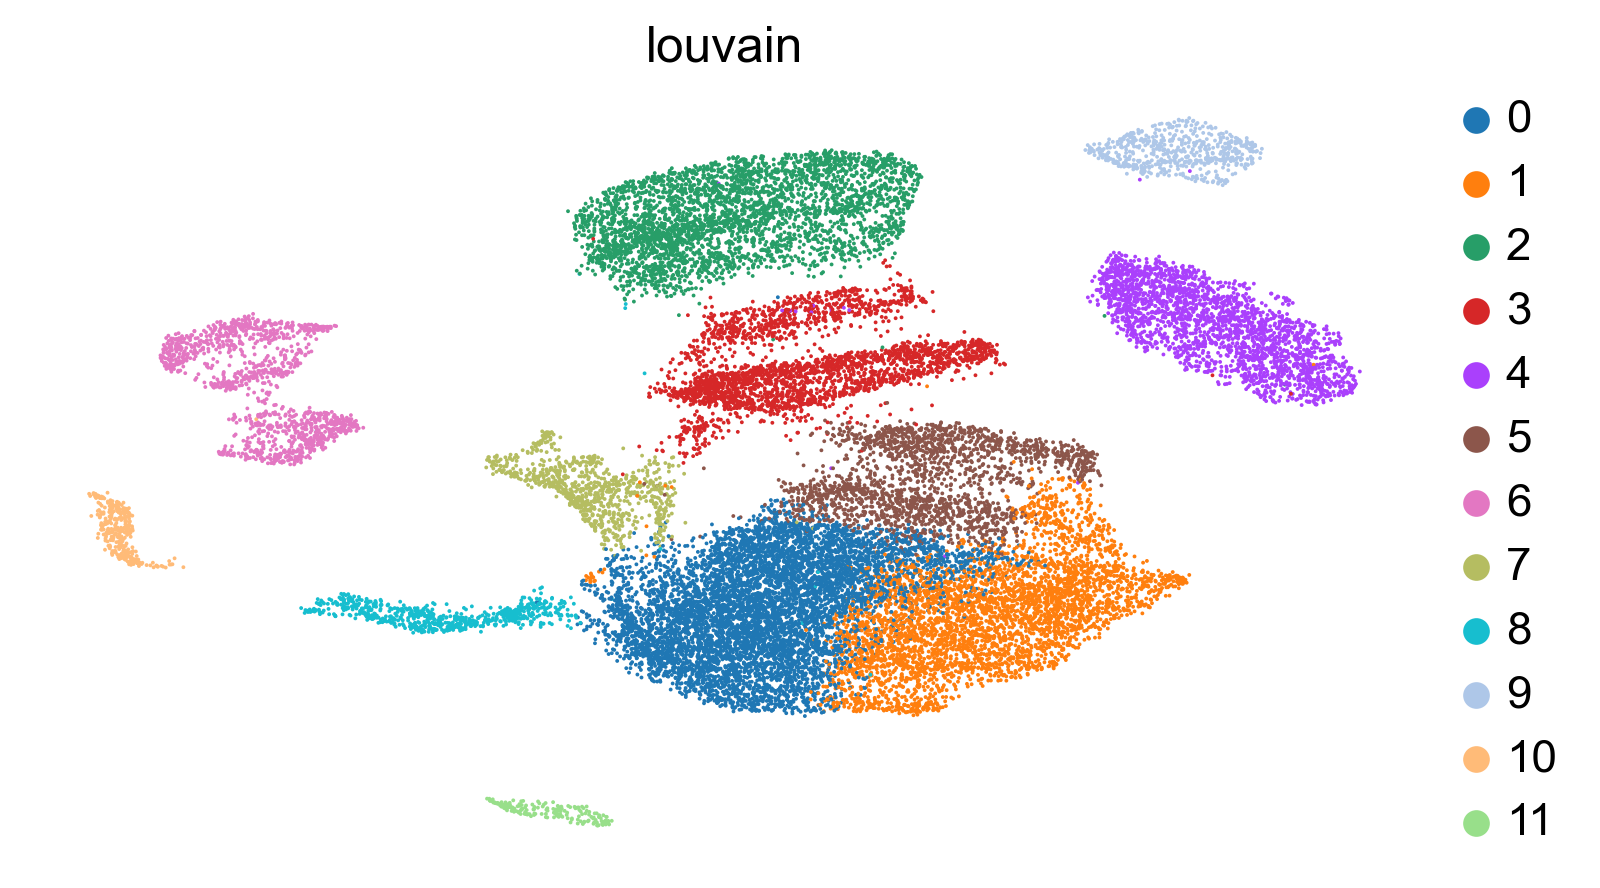

In [51]:
sc.tl.umap(adata_sub['Excitatory'])
sc.pl.umap(adata_sub['Excitatory'], color='louvain')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9990949  0.9982202  0.9978456  0.9973557  0.9969268
     0.99382234 0.992521   0.9913556  0.9893925  0.98781914 0.98485774
     0.98256713 0.9806514  0.9787489 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)


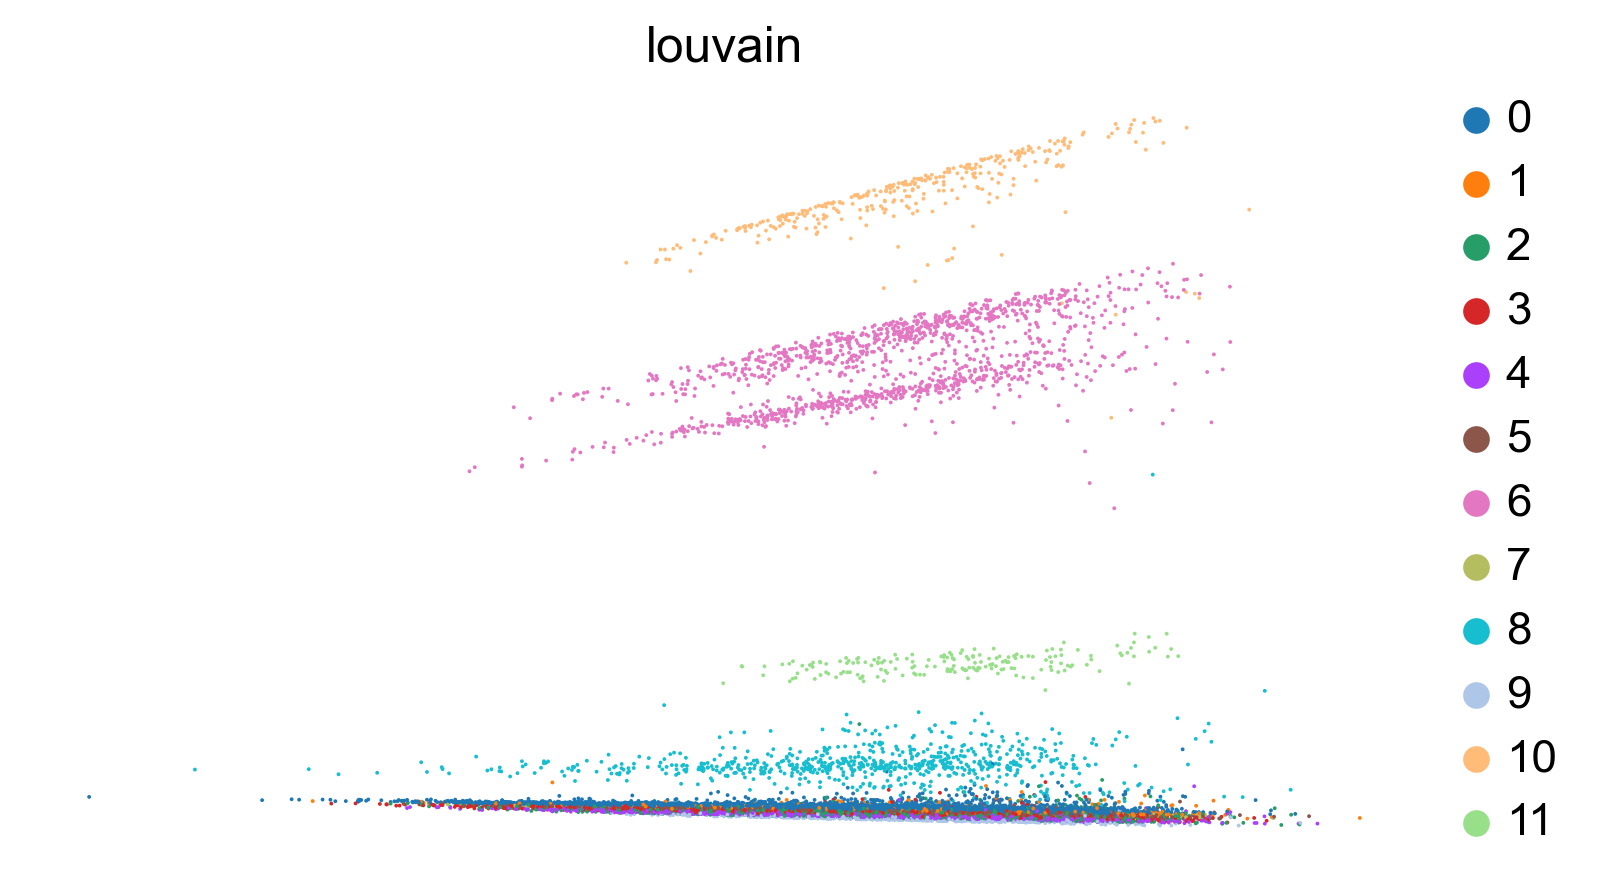

In [52]:
sc.tl.diffmap(adata_sub['Excitatory'])

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:452: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(


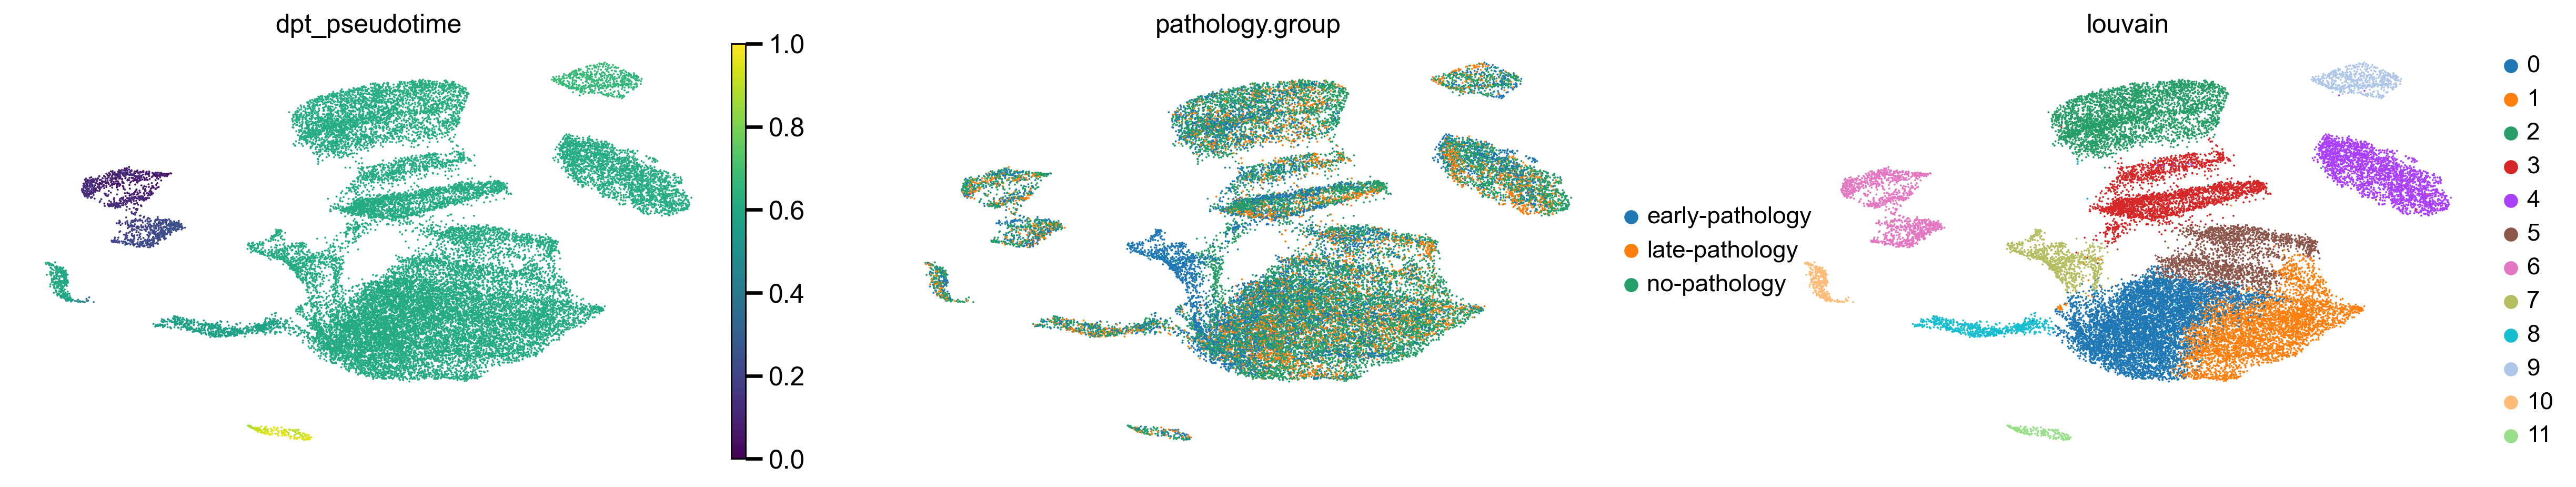

In [56]:
root_ixs = adata_sub['Excitatory'].obsm["X_diffmap"][:, 3].argmin()
adata_sub['Excitatory'].uns["iroot"] = root_ixs
sc.tl.dpt(adata_sub['Excitatory'])
sc.pl.umap(adata_sub['Excitatory'], color=['dpt_pseudotime', 'pathology.group', 'louvain'])

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:622: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = pl.colorbar(


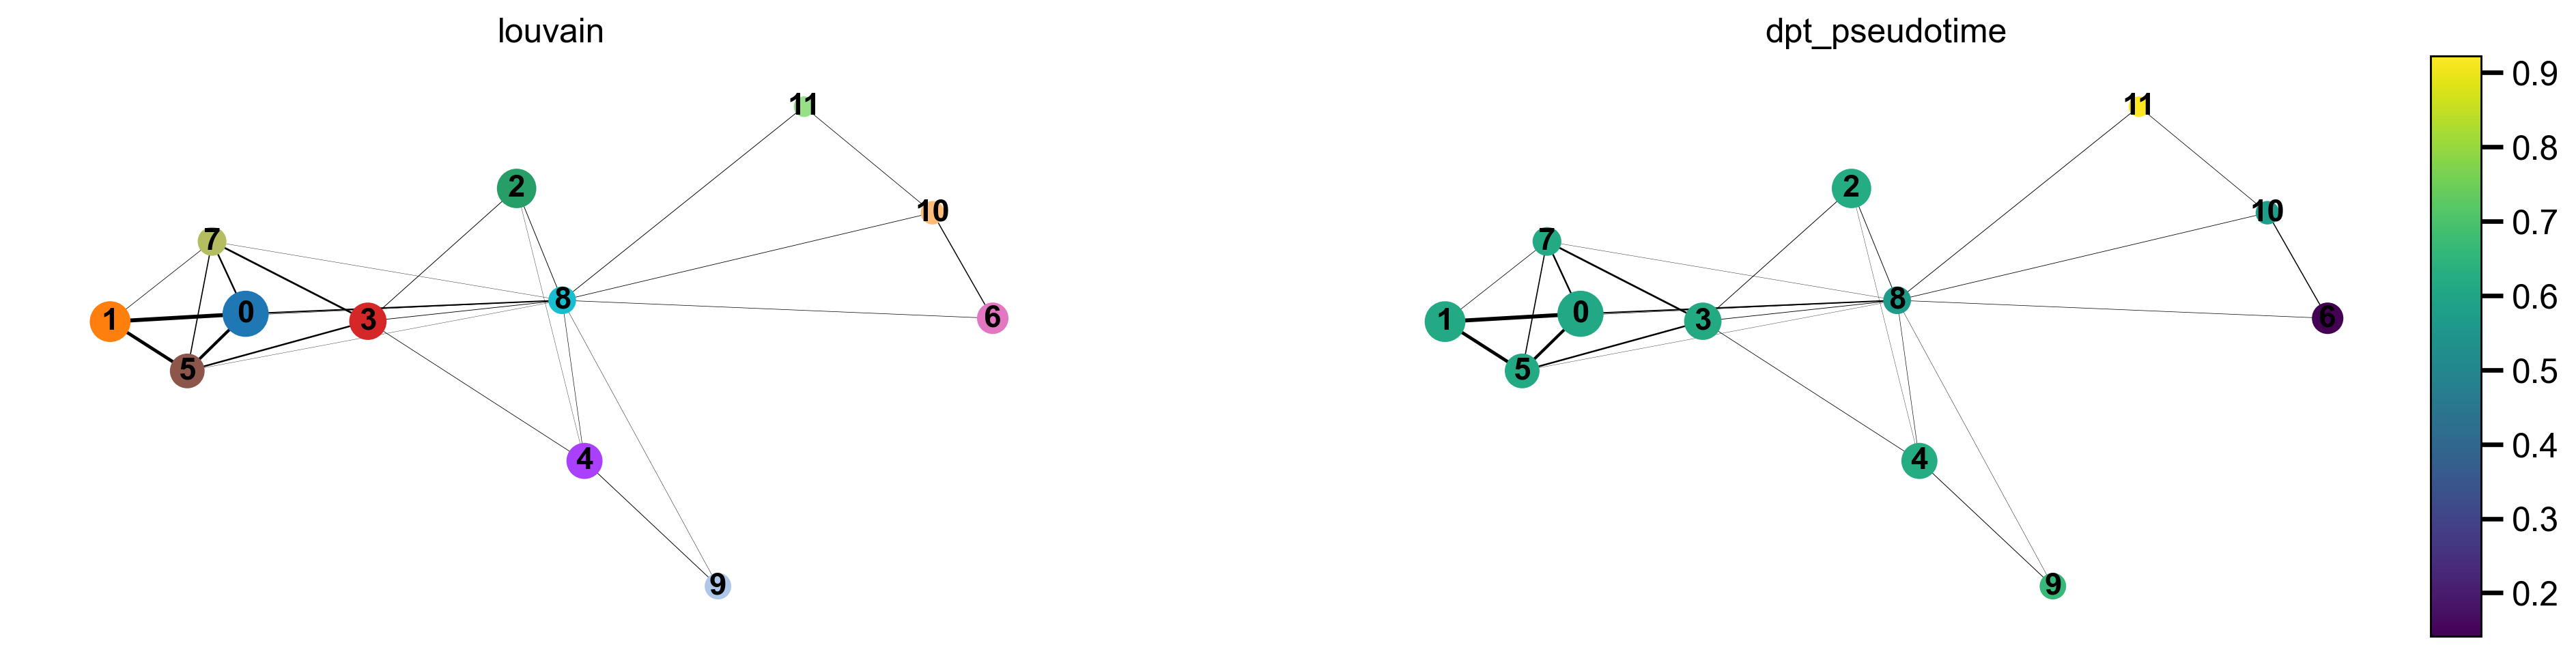

In [62]:
sc.tl.paga(adata_sub['Excitatory'], groups='louvain')
sc.pl.paga(adata_sub['Excitatory'], color=['louvain', 'dpt_pseudotime'])


--> added 'pos', the PAGA positions (adata.uns['paga'])


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:452: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:622: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = pl.colorbar(


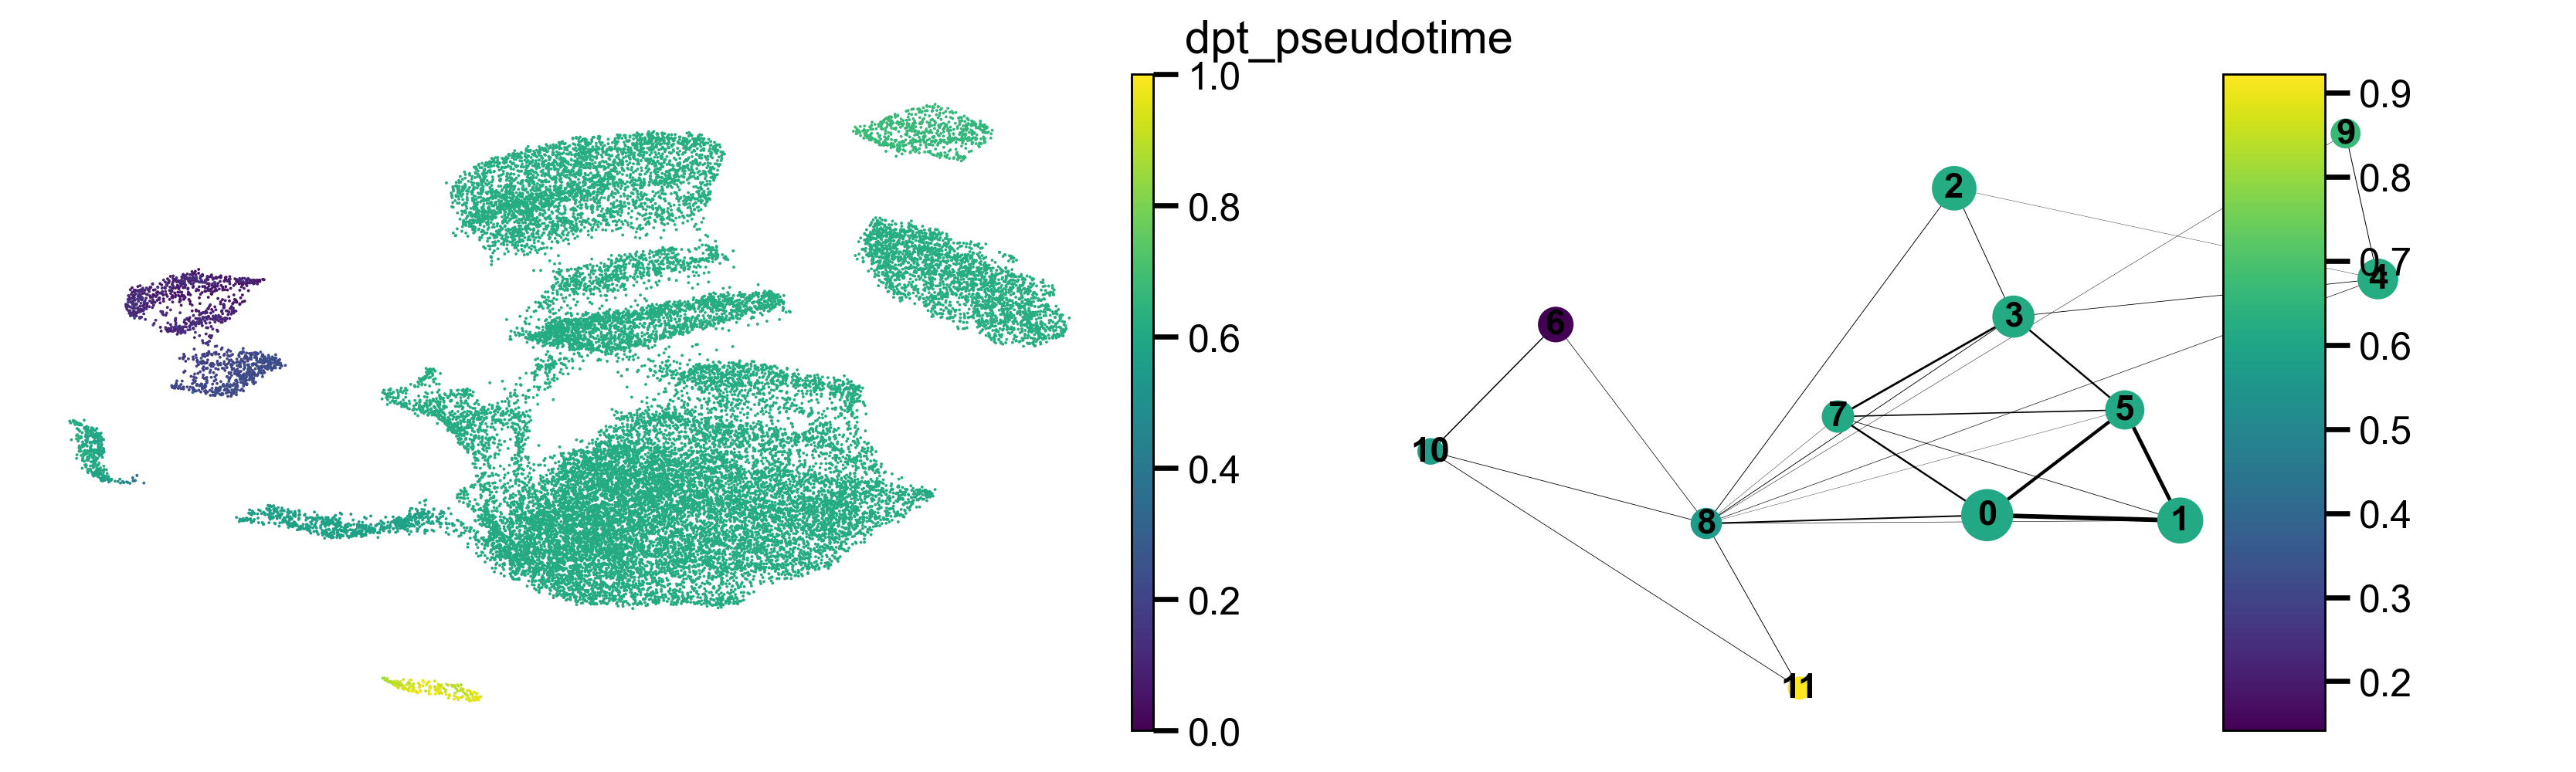

In [64]:
sc.pl.paga_compare(adata_sub['Excitatory'], color='dpt_pseudotime')

--> added 'pos', the PAGA positions (adata.uns['paga'])


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


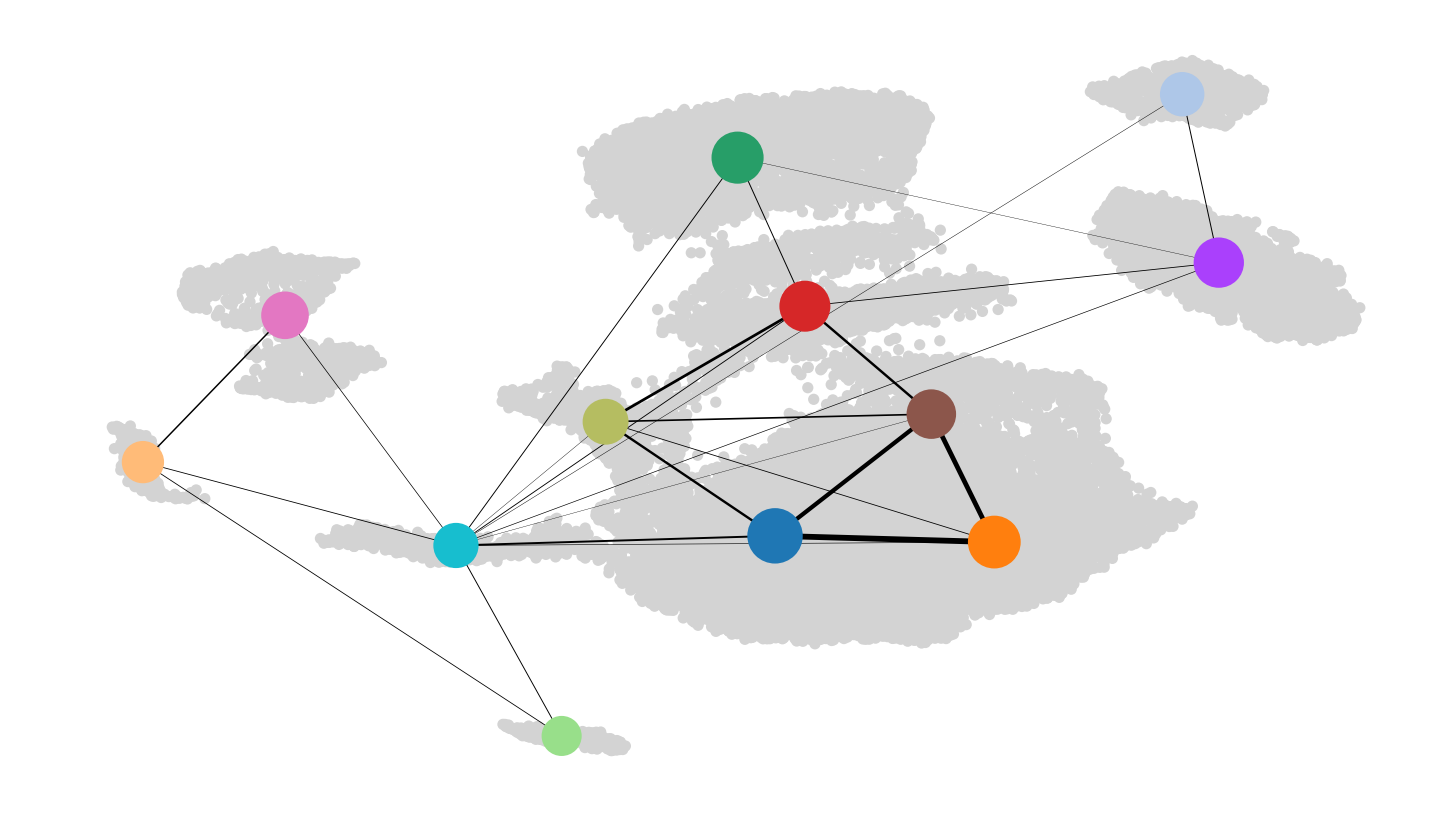

In [71]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata_sub['Excitatory'], size=40, ax=ax1, show=False)
sc.pl.paga(adata_sub['Excitatory'], pos=adata_sub['Excitatory'].uns['paga']['pos'],
          show=False, node_size_scale=1, node_size_power=0.2, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()

In [ ]:
sc.tl.draw_graph(adata_sub['Excitatory'], init_pos='paga')
sc.pl.draw_graph(adata_sub['Excitatory'])

Trajectory inference is often performed on PCA-reduced data, as is the case for Slingshot and Monocle2. To assess how many principal components (PCs) should be included in the low-dimensional representation we can use the 'elbow method'. This method involves looking for the 'elbow' in the plot of the variance ratio explained per PC.

In [72]:
adata_sub['Astrocyte'].obsm['X_pca'] = adata_sub['Astrocyte'].obsm['X_pca'][:,0:7]
adata_sub['Endothelial'].obsm['X_pca'] = adata_sub['Endothelial'].obsm['X_pca'][:,0:5]
adata_sub['Excitatory'].obsm['X_pca'] = adata_sub['Excitatory'].obsm['X_pca'][:,0:7]
adata_sub['Inhibitory'].obsm['X_pca'] = adata_sub['Inhibitory'].obsm['X_pca'][:,0:8]
adata_sub['Microglia'].obsm['X_pca'] = adata_sub['Microglia'].obsm['X_pca'][:,0:7]
adata_sub['Oligodendrocyte'].obsm['X_pca'] = adata_sub['Oligodendrocyte'].obsm['X_pca'][:,0:5]
adata_sub['OPC'].obsm['X_pca'] = adata_sub['OPC'].obsm['X_pca'][:,0:30]

In [73]:
adata_exc = adata_sub['Excitatory'].copy()
adata_inh = adata_sub['Inhibitory'].copy()
adata_oli = adata_sub['Oligodendrocyte'].copy()
adata_ast = adata_sub['Astrocyte'].copy()
adata_end = adata_sub['Endothelial'].copy()
adata_mic = adata_sub['Microglia'].copy()
adata_opc = adata_sub['OPC'].copy()


We are loading the normalized, log-transformed, and batch-corrected data as we want to minimize technical variation in the inferred trajectories.

Implementation note:
- this section closely follows the online Slingshot tutorial

/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/U

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
   25770          7

lineages: 5 
Lineage1: 7  5  3  4  9  
Lineage2: 7  5  1  0  
Lineage3: 7  2  10  8  
Lineage4: 7  2  10  6  
Lineage5: 7  2  11  

curves: 5 
Curve1: Length: 52.952	Samples: 8201.95
Curve2: Length: 56.237	Samples: 13602.19
Curve3: Length: 64.505	Samples: 4045.83
Curve4: Length: 53.999	Samples: 4959.26
Curve5: Length: 46.715	Samples: 4636.31


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:883: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(data=disp_d, source=tag,


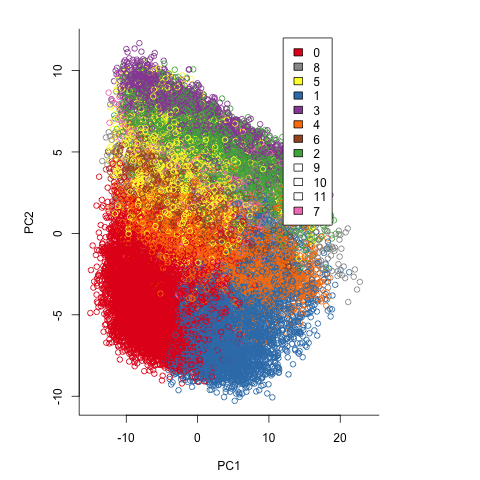

In [74]:
%%R -i adata_exc

library(slingshot)
library(RColorBrewer)

adata_exc <- adata_exc

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata_exc)$PCA[,1], reducedDims(adata_exc)$PCA[,2], col=colour_map[colData(adata_exc)$louvain], bty='L', xlab='PC1', ylab='PC2')
legend(x=12, y=12, legend=unique(colData(adata_exc)$louvain), fill=colour_map[as.integer(unique(colData(adata_exc)$louvain))])

#First trajectory: only no-pathology cells set as root cells
print("1:")
adata_exc_start <- slingshot(adata_exc, clusterLabels = 'louvain', reducedDim = 'PCA', start.clus='7', )
print(SlingshotDataSet(adata_exc_start))

# #Second trajectory: no-pathology cells as root cells and late-pathology cells as end clusters
# print("")
# print("2:")
# adata_exc_startend <- slingshot(adata_exc, clusterLabels = 'louvain', reducedDim = 'PCA', 
#                                 start.clus='no-pathology', end.clus='late-pathology')
# print(SlingshotDataSet(adata_exc_startend))


# #Third trajectory: no-pathology cells as root cells and early-pathology cells as end clusters
# print("3:")
# adata_exc_simple_startend <- slingshot(adata_exc, clusterLabels = 'louvain', reducedDim = 'PCA',
#                              start.clus='no-pathology', end.clus='early-pathology')
# print(SlingshotDataSet(adata_exc_simple_startend))

Here we output three inferred sets of trajectories and a plot of how the data look on a two principal component representation. The plot shows no broad differentiation in cell states from no-pathology to pathology stages as captured within the first two PCs. Therefore, it is not clear whether diseased and non-diseased excitatory cells are separated.

The inferred trajectories can be seen in the 'lineages:' output. In the first trajectory, no endpoints are fixed and only the 'no-pathology' cell compartment is fixed as a starting point; the second trajectory includes fixed late-pathology cells as endpoints; and the third trajectory is performed over the simpler (no- to early-) endpoints without late-pathology cells.

The inferred trajectories show that the detected lineage does not distinguish between no-pathology and late-pathology excitatory neuronal endpoints. The trajectory only shows an overlap of these endpoints in the lineage as can be seen in the PCA plot. In the first two PCs these cell states overlap fully.

The above trajectories can be visualized with Slingshot custom visualization tools.

/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/U

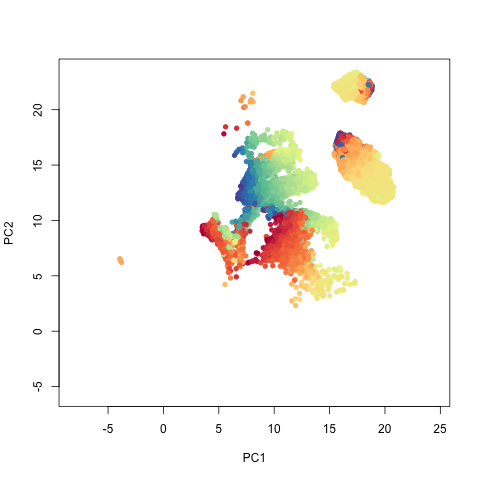

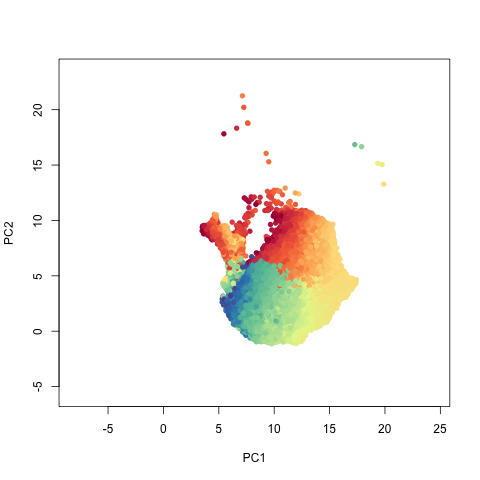

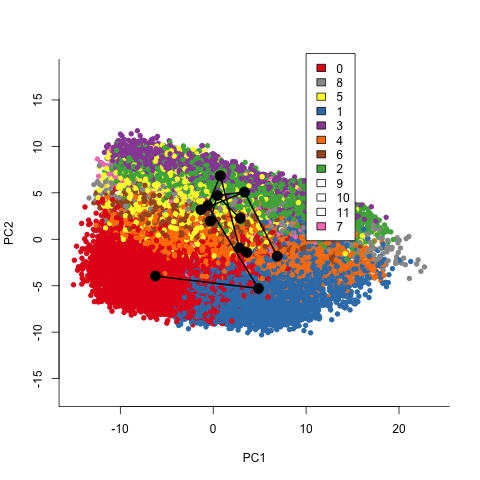

/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


In [92]:
%%R -o adata_exc2

#Plot of lineage 1
par(xpd=TRUE)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_exc_start)$UMAP[,c(1, 2)], col = colors[cut(adata_exc_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_exc_start)$curve1, lwd=5)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_exc_start)$UMAP[,c(1, 2)], col = colors[cut(adata_exc_start$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_exc_start)$curve2, lwd=2)

# #Combined plot
# plot(reducedDims(adata_exc_start)$UMAP[,c(1,2)], col = 'grey',  pch=16, asp = 1, size=0.8, xlab='PC1', ylab='PC2')
# points(reducedDims(adata_exc_start)$UMAP[,c(1,2)], col = colors[cut(adata_exc_start$slingPseudotime_1,breaks=100)], pch=16, size=1)
# lines(slingCurves(adata_exc_start)$curve1, lwd=2)
# lines(slingCurves(adata_exc_start)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_exc_start)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata_exc$louvain], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_exc_start), lwd=2, type='lineages')
legend(x=10, y=20, legend=unique(colData(adata_exc)$louvain), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata_exc)$louvain))])

adata_exc2 <- adata_exc

In [103]:
632.92+701.37+525.73+190+120+120+180+130+240+180+120+835+200-300

3875.0200000000004

In [101]:
700*6

4200

In [ ]:
adata_exc2

AnnData object with n_obs × n_vars = 25770 × 17698
    obs: 'libraryid', 'Subject', 'study', 'age_death', 'educ', 'msex_x', 'gpath_x', 'amyloid_x', 'plaq_n_x', 'cogdx_x', 'pathologic.diagnosis.of.AD', 'amyloid_y', 'plaq_n_y', 'nft', 'tangles', 'cogn_global_lv', 'gpath_y', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx_y', 'msex_y', 'pathology.group', 'fastq', 'projid', 'sampleid', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'cell_type', 'louvain', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'gene_subset', 'highly_variable', 'mean', 'std'
    uns: 'Subject_colors', 'amyloid.group_colors', 'braaksc_colors', 'dendrogram_louvain_0.5', 'hvg', 'log1p', 'louv

In [8]:
!aws s3 cp --no-sign-request s3://sea-ad-single-cell-profiling/MTG/RNAseq/Reference_MTG_RNAseq_all-nuclei.2022-06-07.h5ad ../data/

download: s3://sea-ad-single-cell-profiling/MTG/RNAseq/Reference_MTG_RNAseq_all-nuclei.2022-06-07.h5ad to ../data/Reference_MTG_RNAseq_all-nuclei.2022-06-07.h5ad


In [9]:
adata_seaad = sc.read_h5ad('../data/Reference_MTG_RNAseq_all-nuclei.2022-06-07.h5ad')

In [10]:
adata_seaad

AnnData object with n_obs × n_vars = 166868 × 36601
    obs: 'sample_name', 'donor_sex_label', 'external_donor_name_label', 'species_label', 'age_label', 'region_label', 'cortical_layer_label', 'full_genotype_label', 'QCpass', 'cluster_label', 'cluster_confidence', 'subclass_label', 'subclass_confidence', 'class_label', 'class_confidence', 'GA_QCpass', 'GA_cluster_label', 'GA_subclass_label', 'GA_neighborhood_label', 'CA_QCpass', 'CA_cluster_label', 'CA_subclass_label', 'CA_neighborhood_label', 'cluster_color', 'cluster_order', 'subclass_color', 'subclass_order', 'class_color', 'class_order', 'GA_cluster_color', 'GA_cluster_order', 'GA_subclass_color', 'GA_subclass_order', 'CA_cluster_color', 'CA_cluster_order', 'CA_subclass_color', 'CA_subclass_order', 'cell_type_accession_label'